<a href="https://colab.research.google.com/github/amazingashis/Hackfest/blob/master/Copy_of_CONVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline
import pandas.util.testing as tm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
train = get_training_data('/content/drive/MyDrive/Data/data/chest-xray-pneumonia/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/Data/data/chest-xray-pneumonia/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/Data/data/chest-xray-pneumonia/chest_xray/val')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [6]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


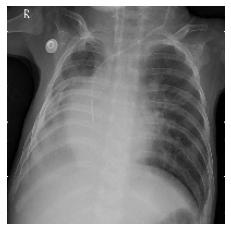

In [7]:
plt.imshow(train[500][0],cmap = 'gray')
plt.axis('off')
print(labels[train[500][1]])

In [8]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [9]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [10]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [11]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 256)     2560      
_________________________________________________________________
activation (Activation)      (None, 200, 200, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 256)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 256)     400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      147520    
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 1487s 4s/step - loss: 0.7417 - acc: 0.6926 - val_loss: 0.6014 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 1517s 4s/step - loss: 0.5372 - acc: 0.7230 - val_loss: 0.4465 - val_acc: 0.7759
Epoch 3/15
375/375 [==============================] - 1521s 4s/step - loss: 0.4523 - acc: 0.7761 - val_loss: 0.3437 - val_acc: 0.8549
Epoch 4/15
375/375 [==============================] - 1524s 4s/step - loss: 0.4176 - acc: 0.8090 - val_loss: 0.3621 - val_acc: 0.8100
Epoch 5/15
375/375 [==============================] - 1527s 4s/step - loss: 0.3964 - acc: 0.8275 - val_loss: 0.2953 - val_acc: 0.8762
Epoch 6/15
267/375 [====================>.........] - ETA: 6:56 - loss: 0.3546 - acc: 0.8446

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()